![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [565]:
import numpy as np
import pandas as pd

import pickle

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, precision_recall_curve, auc

from keras.utils import np_utils

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import TensorBoard

In [566]:
# import configurations (file paths, etc.)
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
    
configFile = '../cluster/data/medinfmk/ddi/config/config.yml'

with open(configFile, 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=Loader)

In [567]:
pathInput = cfg['filePaths']['dirRaw']
pathOutput = cfg['filePaths']['dirProcessed']
# path to store python binary files (pickles)
# in order not to recalculate them every time
pathPickles = cfg['filePaths']['dirProcessedFiles']['dirPickles']
pathRuns = cfg['filePaths']['dirProcessedFiles']['dirRuns']
pathPaperScores = cfg['filePaths']['dirRawFiles']['paper-individual-metrics-scores']
datasetDirs = cfg['filePaths']['dirRawDatasets']
DS1_path = str(datasetDirs[0])

# Helper Functions

In [568]:
def prepare_data(input_fea, input_lab, seperate=False):
    offside_sim_path = input_fea
    drug_interaction_matrix_path = input_lab
    drug_fea = np.loadtxt(offside_sim_path,dtype=float,delimiter=",")
    interaction = np.loadtxt(drug_interaction_matrix_path,dtype=int,delimiter=",")
    
    train = []
    label = []
    tmp_fea=[]
    drug_fea_tmp = []
            
    for i in range(0, (interaction.shape[0]-1)):
        for j in range((i+1), interaction.shape[1]):
            label.append(interaction[i,j])
            drug_fea_tmp_1 = list(drug_fea[i])
            drug_fea_tmp_2 = list(drug_fea[j])
            if seperate:
                 tmp_fea = (drug_fea_tmp_1,drug_fea_tmp_2)
            else:
                 tmp_fea = drug_fea_tmp_1 + drug_fea_tmp_2
            train.append(tmp_fea)

    return np.array(train), np.array(label)

In [569]:
def transfer_array_format(data):
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])
        formated_matrix2.append(val[1])
    return np.array(formated_matrix1), np.array(formated_matrix2)

In [570]:
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
        y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
        print(y)
    return y, encoder

In [571]:
def preprocess_names(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    if categorical:
        labels = np_utils.to_categorical(labels)
    return labels, encoder

In [572]:
def do_stratifiedKFold(X,y,n_splits):
    skf = StratifiedKFold(n_splits=n_splits)
    skf.get_n_splits(X, y)
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

In [573]:
class NDD(nn.Module):
    def __init__(self, D_in=123, H1=300, H2=400, D_out=2, drop=0.5):
        super(NDD, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(D_in, H1) # Fully Connected
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, D_out)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [574]:
def updateSimilarityDFSingleMetric(df, sim_type, metric, value):
    df.loc[df['Similarity'] == sim_type, metric ] = value
    return df

In [575]:
def updateSimilarityDF(df, sim_type, AUROC, AUPR, F1, Rec, Prec):
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUC', AUROC)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUPR', AUPR)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'F-measure', F1)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Recall', Rec)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Precision', Prec)
    return df

In [576]:
def writeReplicatedIndividualScoresCSV(net, df, destination, str_hidden_layers_params):
    net_params_to_print = ["max_epochs", "batch_size"]
    net_params = [val for sublist in [[x,net.get_params()[x]] for x in net_params_to_print] for val in sublist]
    net_params_string = '-'.join(map(str, flattened))
        
    filePath = destination + "replicatedIndividualScores_" + net_params_string + str_hidden_layers_params + ".csv"
    #print(filePath)
    
    df.to_csv(path_or_buf = filePath, index=False)

# Run

In [577]:
df_paperIndividualScores = pd.read_csv(pathPaperScores)

df_replicatedIndividualScores = df_paperIndividualScores.copy()

for col in df_replicatedIndividualScores.columns:
    if col != 'Similarity':
        df_replicatedIndividualScores[col].values[:] = 0

In [578]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
do_prepare_data = False
soft = nn.Softmax(dim=1)
similaritiesToRun = df_paperIndividualScores['Similarity']
# similaritiesToRun = ["chem"]

for similarity in similaritiesToRun:
    input_fea = pathInput+DS1_path+"/" + similarity + "_Jacarrd_sim.csv"
    input_lab = pathInput+DS1_path+"/drug_drug_matrix.csv"
    dataPicklePath = pathPickles+"data_X_y_" + similarity + "_Jaccard.p"

    # Prepare data if not available
    if do_prepare_data:
        X,y = prepare_data(input_fea, input_lab, seperate = False)

        with open(dataPicklePath, 'wb') as f:
            pickle.dump([X, y], f)

    # Load X,y and split in to train, test
    with open(dataPicklePath, 'rb') as f:
        X, y = pickle.load(f)
    
    X = X.astype(np.float32)
    y = y.astype(np.int64)    
    X_train, X_test, y_train, y_test = do_stratifiedKFold(X,y,n_splits=5)
    
    # Define model
    D_in, H1, H2, D_out, drop = X.shape[1], 400, 300, 2, 0.5
    str_hidden_layers_params = "-H1-" + str(H1) + "-H2-" + str(H2)
    model = NDD(D_in, H1, H2, D_out, drop)
    callbacks = []

    # Define Network Classifier
    net = NeuralNetClassifier(
        model,
        criterion=nn.CrossEntropyLoss,
        max_epochs=20,
        optimizer=SGD,
        optimizer__lr=0.01,
        optimizer__momentum=0.9,    
        optimizer__weight_decay=1e-6,    
        optimizer__nesterov=True,    
        batch_size=200,
        callbacks=callbacks,
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
        device=device,
    )
    
    # Fit network and make predictions
    net.fit(X_train, y_train)
    y_pred = net.predict(X_test)
    #lr_probs = net.predict_proba(X_train)
#     lr_probs = lr_probs[:, 1]
    lr_probs = soft(net.forward(X_test))[:,1]
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     AUPR = auc(lr_recall, lr_precision)
#     print(AUPR)
    AUROC, AUPR, F1, Rec, Prec = roc_auc_score(y_test, y_pred), auc(lr_recall, lr_precision), f1_score(y_test, y_pred), recall_score(y_test, y_pred), precision_score(y_test, y_pred)
    print(similarity, AUROC, AUPR, F1, Rec, Prec)
#     break
    
    # Fill replicated metrics
    updateSimilarityDF(df_replicatedIndividualScores, similarity, AUROC, AUPR, F1, Rec, Prec)
    
# Write CSV
writeReplicatedIndividualScoresCSV(net, df_replicatedIndividualScores, pathRuns, str_hidden_layers_params)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6282       0.6758        0.6277  2.1116
      2        0.6194       0.6758        0.6260  1.9659
      3        0.6127       0.6758        0.6252  1.9548
      4        0.6070       0.6760        0.6191  1.9722
      5        0.6032       0.6760        0.6195  2.3323
      6        0.6009       0.6758        0.6273  1.9607
      7        0.6026       0.6809        0.6169  1.9594
      8        0.5996       0.6814        0.6375  1.9716
      9        0.6032       0.6758        0.6277  1.9773
     10        0.6068       0.6753        0.6224  1.9695
     11        0.6029       0.6760        0.6187  2.0559
     12        0.6023       0.6758        0.6244  1.9461
     13        0.6083       0.6760        0.6207  1.9629
     14        0.6100       0.6758        0.6258  2.0890
     15        0.6059       0.6758        0.6506  1.9467
     16        0.6083       0.6

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6274       0.6758        0.6240  2.3880
      2        0.5779       0.6925        0.5995  2.0850
      3        0.4753       0.6877        0.6153  2.0598
      4        0.4175       0.7169        0.5765  1.9804
      5        0.3931       0.7269        0.5791  1.9462
      6        0.3798       0.7180        0.5983  1.9834
      7        0.3690       0.7054        0.6555  1.9807
      8        0.3598       0.7270        0.6317  1.9571
      9        0.3540       0.7268        0.6241  1.9383
     10        0.3497       0.7352        0.6273  2.3650
     11        0.3447       0.7376        0.6014  1.9388
     12        0.3383       0.7351        0.6225  1.9082
     13        0.3351       0.7367        0.6315  1.9713
     14        0.3319       0.7324        0.6554  1.9432
     15        0.3276       0.7211        0.7134  2.1640
     16        0.3256       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6074       0.6843        0.6155  1.9801
      2        0.5723       0.6763        0.6267  1.9306
      3        0.5448       0.6763        0.6363  1.9598
      4        0.5260       0.7034        0.6305  2.0192
      5        0.5169       0.7033        0.6309  1.9597
      6        0.5103       0.7085        0.6112  2.0755
      7        0.5060       0.7117        0.6067  1.9434
      8        0.5032       0.7108        0.6246  1.9238
      9        0.4989       0.7096        0.6025  1.9691
     10        0.4976       0.7081        0.6083  1.9986
     11        0.4949       0.7103        0.6234  1.9577
     12        0.4938       0.7159        0.6027  1.9784
     13        0.4922       0.7174        0.6103  1.9720
     14        0.4903       0.7191        0.6063  1.9735
     15        0.4898       0.7182        0.6054  1.9586
     16        0.4891       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6039       0.6908        0.6005  1.9825
      2        0.5505       0.7106        0.5822  1.9803
      3        0.5048       0.6990        0.5902  2.2712
      4        0.4829       0.7084        0.5859  1.7887
      5        0.4716       0.7023        0.5876  1.8173
      6        0.4640       0.6980        0.5927  1.8988
      7        0.4575       0.6964        0.5882  1.7547
      8        0.4524       0.7028        0.5868  1.7294
      9        0.4490       0.7054        0.5750  1.7289
     10        0.4455       0.7049        0.5988  1.7294
     11        0.4431       0.7097        0.5778  1.7223
     12        0.4400       0.7094        0.5816  1.7031
     13        0.4387       0.7144        0.5787  1.7204
     14        0.4358       0.7060        0.5997  1.9412
     15        0.4363       0.7164        0.5827  1.9369
     16        0.4330       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6191       0.6706        0.6250  2.2629
      2        0.5552       0.6963        0.6064  2.4614
      3        0.4922       0.6751        0.6220  1.9628
      4        0.4626       0.6440        0.6540  2.3976
      5        0.4438       0.6812        0.6412  2.2610
      6        0.4308       0.6806        0.6323  2.3836
      7        0.4207       0.7190        0.5998  1.9757
      8        0.4147       0.7230        0.5927  2.0211
      9        0.4059       0.6743        0.6662  1.9393
     10        0.3999       0.7310        0.5934  1.9799
     11        0.3965       0.7134        0.6199  2.3918
     12        0.3911       0.6910        0.6694  2.0182
     13        0.3885       0.7109        0.6330  1.9491
     14        0.3854       0.7254        0.6136  2.0057
     15        0.3828       0.7056        0.6502  1.9338
     16        0.3807       0.6

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5907       0.7156        0.5667  1.7514
      2        0.4633       0.7095        0.5710  2.0386
      3        0.3857       0.7123        0.6021  1.9830
      4        0.3474       0.7226        0.6110  1.9596
      5        0.3249       0.7145        0.6547  1.9835
      6        0.3095       0.7124        0.6707  1.9833
      7        0.3003       0.7142        0.6814  1.9693
      8        0.2912       0.7177        0.7082  1.7500
      9        0.2858       0.7244        0.6806  1.9393
     10        0.2794       0.7214        0.6779  1.9536
     11        0.2729       0.7250        0.7016  1.9436
     12        0.2689       0.7259        0.7006  1.9251
     13        0.2659       0.7260        0.7170  2.2939
     14        0.2601       0.7240        0.7283  2.2916
     15        0.2567       0.7243        0.7383  2.3986
     16        0.2539       0.7

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5894       0.6942        0.5864  2.1084
      2        0.5557       0.6965        0.5918  2.3098
      3        0.5317       0.6853        0.6446  2.0340
      4        0.5218       0.6942        0.5869  1.9918
      5        0.5166       0.7166        0.5744  1.8582
      6        0.5164       0.7043        0.5811  1.8675
      7        0.5131       0.7091        0.5792  1.9601
      8        0.5175       0.6953        0.5848  2.3063
      9        0.5149       0.7038        0.5778  2.2238
     10        0.5151       0.7117        0.5848  1.9605
     11        0.5179       0.6960        0.5825  1.9181
     12        0.5243       0.6970        0.5768  1.9881
     13        0.5209       0.6654        0.6072  1.9655
     14        0.5153       0.7194        0.5646  2.0132
     15        0.5131       0.6982        0.5838  1.9605
     16        0.5206       0.6

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:937: FutureWarning: Passing all_or_any to check_is_fitted is deprecated and will be removed in 0.23. The any_or_all argument is ignored.
  "argument is ignored.", FutureWarning)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5728       0.7222        0.5564  2.2337
      2        0.5080       0.7318        0.5279  2.0779
      3        0.4730       0.7513        0.4952  2.1504
      4        0.4635       0.7592        0.4870  2.0820
      5        0.4598       0.7727        0.4796  2.1021
      6        0.4544       0.6734        0.5761  2.0370
      7        0.4604       0.7503        0.5092  1.9956
      8        0.4592       0.6978        0.5511  1.9166
      9        0.4587       0.7281        0.5240  1.9654
     10        0.4574       0.7681        0.4821  1.9344
     11        0.4653       0.7350        0.5156  1.9338
     12        0.4695       0.7443        0.5148  1.9540
     13        0.4610       0.7624        0.4937  1.9390
     14        0.4699       0.7050        0.5478  1.9404
     15        0.4776       0.7595        0.4943  1.9764
     16        0.4696       0.7

# Compare to Paper

In [579]:
print(df_paperIndividualScores)

      Similarity    AUC   AUPR  F-measure  Recall  Precision
0           chem  0.631  0.455      0.527   0.899      0.373
1         target  0.787  0.642      0.617   0.721      0.540
2    transporter  0.682  0.568      0.519   0.945      0.358
3         enzyme  0.734  0.599      0.552   0.579      0.529
4        pathway  0.767  0.623      0.587   0.650      0.536
5     indication  0.802  0.654      0.632   0.740      0.551
6     sideeffect  0.778  0.601      0.619   0.748      0.528
7  offsideeffect  0.782  0.606      0.617   0.764      0.517


In [580]:
print(df_replicatedIndividualScores)

      Similarity       AUC      AUPR  F-measure    Recall  Precision
0           chem  0.513179  0.379333   0.101424  0.056814   0.472198
1         target  0.634882  0.480986   0.506014  0.504426   0.507613
2    transporter  0.594447  0.417584   0.451500  0.450803   0.452199
3         enzyme  0.613513  0.485284   0.520726  0.696892   0.415654
4        pathway  0.604781  0.453810   0.489812  0.564121   0.432802
5     indication  0.678513  0.600967   0.570838  0.610642   0.535905
6     sideeffect  0.607861  0.453908   0.541778  0.907266   0.386199
7  offsideeffect  0.741949  0.650899   0.650398  0.891519   0.511939


In [581]:
diff_metrics = ['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']
df_diff = df_paperIndividualScores[diff_metrics] - df_replicatedIndividualScores[diff_metrics]
df_diff_abs = df_diff.abs()
df_diff_percent = (df_diff_abs / df_paperIndividualScores[diff_metrics]) * 100

In [582]:
df_diff

,AUC,AUPR,F-measure,Recall,Precision
0,0.117821,0.075667,0.425576,0.842186,-0.099198
1,0.152118,0.161014,0.110986,0.216574,0.032387
2,0.087553,0.150416,0.067500,0.494197,-0.094199
3,0.120487,0.113716,0.031274,-0.117892,0.113346
4,0.162219,0.169190,0.097188,0.085879,0.103198
5,0.123487,0.053033,0.061162,0.129358,0.015095
6,0.170139,0.147092,0.077222,-0.159266,0.141801
7,0.040051,-0.044899,-0.033398,-0.127519,0.005061


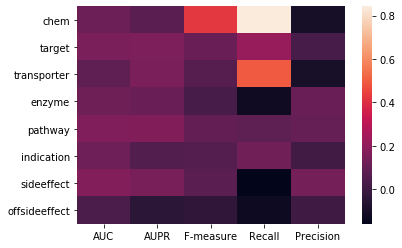

In [583]:
from seaborn import heatmap
heatmap(df_diff, yticklabels=df_paperIndividualScores["Similarity"])

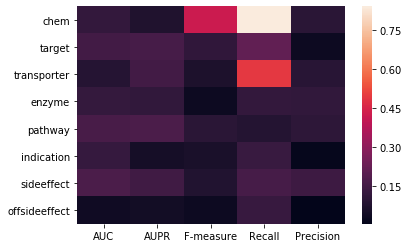

In [584]:
heatmap(df_diff_abs, yticklabels=df_paperIndividualScores["Similarity"])

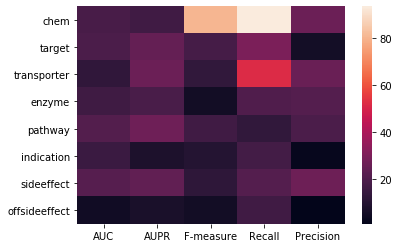

In [585]:
heatmap(df_diff_percent, yticklabels=df_paperIndividualScores["Similarity"])

In [586]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_paperIndividualScores[['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']],
                   df_replicatedIndividualScores[['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']])

0.04041291487692449